# **Catégorisez automatiquement des questions**

## partie 1/8 : analyse exploratoire

### <br> Notebook d’exploration et de pré-traitement des questions, comprenant une analyse univariée et multivariée, un nettoyage des questions, un feature engineering de type bag of words avec réduction de dimension (du vocabulaire et des tags) 

<br>


## 1 Objectifs, imports


### 1.1 Contexte


In [114]:
# Nous avons téléchargé 50 000 questions posées sur stack overflow,
# ainsi que les tags associés.

# Objectifs de notebook :

# Comprendre nos données (forme, structure)
# premier nettoyage -> reduction dim
# Avoir une première représentation de nos données
# Rechercher des patterns
# se faire une idée de la difficulté de la tâche (prédiction de tags)
# (encore et surtout) : transformations en vue de reduction dim

# => traitement de strings avec nltk, regex, etc..
# tester spacy

# Dans le cadre de ce projet :
# Nous avons en input un fichier csv contenant 50 000 titres, questions (body), tags, etc...
# Nous avons besoin en output de représentations spécifiques, pour nos différents modèles.

# Pour les modèles non-supervisé, il nous faut :
# - un bag of words pour la LDA (/algos similaires)
# - un TS-IDF pour la NMF
# Dans les deux cas, cela implique un cleaning "aggressif", visant à conserver uniquement
# les mots qui ont du sens pour ce projet (= qui aident la prédiction de tag par les modèles).
# encore et tjs, la reduction dim !

# / supervisés ?


### 1.2 Importation des librairies, réglages


In [115]:
import os, sys, random
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandarallel import pandarallel

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from PIL import Image

# NLP
from bs4 import BeautifulSoup
import re, string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from collections import Counter
# if necessary
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
import spacy

print('\nPython version ' + sys.version)
print('pandas version ' + pd.__version__)
print('sns version ' + sns.__version__)

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
sns.set(font_scale=1)

# Make sure we downloaded the models successfully
nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_md")

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Python version 3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]
pandas version 2.1.1
sns version 0.12.2

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 1.3 Fonctions


In [116]:
# Principalement des fonctions pour l'affichage des graphiques pdt l'EDA

def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


def lerp(a, b, t):
    """
    Linear interpolation between two values 'a' and 'b' at a parameter 't'.
    A very useful little function, used here to position annotations in plots.
    Got it coding with Radu :)

    Given two values 'a' and 'b', and a parameter 't',
    this function calculates the linear interpolation between 'a' and 'b' at 't'.

    Parameters:
    a (float or int): The start value.
    b (float or int): The end value.
    t (float): The interpolation parameter (typically in the range [0, 1], but can be outside).

    Returns:
    float or int: The interpolated value at parameter 't'.
    """
    return a + (b - a) * t


def generate_random_pastel_colors(n):
    """
    Generates a list of n random pastel colors, represented as RGBA tuples.

    Parameters:
    n (int): The number of pastel colors to generate.

    Returns:
    list: A list of RGBA tuples representing random pastel colors.

    Example:
    >>> generate_random_pastel_colors(2)
    [(0.749, 0.827, 0.886, 1.0), (0.886, 0.749, 0.827, 1.0)]
    """
    colors = []
    for _ in range(n):
        # Generate random pastels
        red = round(random.randint(150, 250) / 255.0, 3)
        green = round(random.randint(150, 250) / 255.0, 3)
        blue = round(random.randint(150, 250) / 255.0, 3)

        # Create an RGB color tuple and add it to the list
        color = (red,green,blue, 1.0)
        colors.append(color)

    return colors

print(generate_random_pastel_colors(2))


def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def hist_distrib(dataframe, feature, bins, decimal_places, density=True):
    """
    Visualize the empirical distribution of a numerical feature using a histogram.
    Calcul des principaux indicateurs de tendance centrale, dispersion et forme.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.
        bins (int): The number of bins for the histogram.
        decimal_places (int): The number of decimal places for rounding numeric values.
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    Returns:
        float: The skewness of the feature's distribution.

    The function generates a histogram of the feature, displays various statistics, and returns the skewness of the distribution.
    """
    # Calculate central tendencies and dispersion
    mode_value = round(dataframe[feature].mode()[0], decimal_places)
    mode_non_zero = "N/A"
    if (dataframe[feature] != 0).any():
        mode_non_zero = round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], decimal_places)
    median_value = round(dataframe[feature].median(), decimal_places)
    mean_value = round(dataframe[feature].mean(), decimal_places)

    # Calculate dispersion
    var_emp = round(dataframe[feature].var(ddof=0), decimal_places)
    coeff_var = round(dataframe[feature].std(ddof=0), decimal_places)

    # Calculate shape indicators
    skewness_value = round(dataframe[feature].skew(), 2)
    kurtosis_value = round(dataframe[feature].kurtosis(), 2)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    dataframe[feature].hist(density=density, bins=bins, ax=ax)

    # Adjust placement for annotations
    yt = plt.yticks()
    y_position = lerp(yt[0][0], yt[0][-1], 0.8)
    y_increment = y_position / 20
    xt = plt.xticks()
    x_position = lerp(xt[0][0], xt[0][-1], 0.7)

    # Add annotations with horizontal and vertical alignment
    annotation_fs = 13
    color = 'g'
    ax.annotate(f'Mode: {mode_value}', xy=(x_position, y_position), fontsize=annotation_fs,
                xytext=(x_position, y_position), color=color, ha='left', va='bottom')
    ax.annotate(f'Mode +: {mode_non_zero}', xy=(x_position, y_position - y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Median: {median_value}', xy=(x_position, y_position - 2 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 2 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Mean: {mean_value}', xy=(x_position, y_position - 3 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 3 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Var Emp: {var_emp}', xy=(x_position, y_position - 5 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 5 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Coeff Var: {coeff_var}', xy=(x_position, y_position - 6 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 6 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Skewness: {skewness_value}', xy=(x_position, y_position - 8 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 8 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Kurtosis: {kurtosis_value}', xy=(x_position, y_position - 9 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 9 * y_increment), color=color, ha='left', va='bottom')

    # Label the x-axis and y-axis
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # Show the plot
    plt.title(f'Distribution of {feature}', pad=20, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    return skewness_value


def boxplot_distrib(dataframe, feature):
    """
    Affiche un boxplot, pour visualiser les tendances centrales et la dispersion d'une variable.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a box plot of the feature to display central tendencies (median and mean) and dispersion.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    medianprops = {'color':"blue"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

    dataframe.boxplot(feature, vert=False, showfliers=False, medianprops=medianprops, patch_artist=True, showmeans=True, meanprops=meanprops)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def courbe_lorenz(dataframe, feature):
    """
    Affiche une courbe de Lorenz, pour visualiser la concentration d'une variable
    Calcule l'indice de Gini
    Visualize a Lorenz curve to assess the concentration of a variable and calculate the Gini coefficient.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a Lorenz curve to assess the concentration of the feature and calculates the Gini coefficient.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    values = dataframe.loc[dataframe[feature].notna(), feature].values
    # print(values)
    n = len(values)
    lorenz = np.cumsum(np.sort(values)) / values.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0.
    # #Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot(np.arange(2),[x for x in np.arange(2)])
    # calcul de l'indice de Gini
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    plt.annotate('gini =  ' + str(round(gini, 2)), xy = (0.04, 0.88), fontsize = 13, xytext = (0.04, 0.88), color = 'g')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def graphs_analyse_uni(dataframe, feature, bins=50, r=5, density=True):
    """
    Affiche histogramme + boxplot + courbe de Lorenz

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to analyze.
        bins (int, optional): The number of bins for the histogram (default is 50).
        decimal_places (int, optional): The number of decimal places for rounding numeric values (default is 5).
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    The function generates and displays an analysis of the given numerical feature, including an histogram, a box plot, and a Lorenz curve.
    """
    hist_distrib(dataframe, feature, bins, r)
    boxplot_distrib(dataframe, feature)
    courbe_lorenz(dataframe, feature)


def shape_head(df, nb_rows=5):
    """
    Affiche les dimensions et les premières lignes dùun dataframe
    Display the dimensions and the first rows of a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame to display.
        nb_rows (int, optional): The number of rows to display (default is 5, max is 60).

    The function prints the dimensions of the DataFrame and displays the first few rows.
    """
    print(df.shape)
    display(df.head(nb_rows))


def doughnut(df, feature, title, width=10, height=10):
    """
    Affiche la répartition d'une feature sous forme de diagramme circulaire
    Display the distribution of a feature as a doughnut chart.
    Les couleurs sont aléatoires.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the feature to visualize.
        title (str): The title for the doughnut chart.
        width (int, optional): The width of the chart (default is 10).
        height (int, optional): The height of the chart (default is 10).

    The function creates a doughnut chart to visualize the distribution of the specified feature.
    If you don't like the colors, try running it again :)
    """
    colors = generate_random_pastel_colors(20)

    grouped_df = df.groupby(feature).size().to_frame("count_per_type").reset_index()
    pie = grouped_df.set_index(feature).copy()

    fig, ax = plt.subplots(figsize=(width, height))

    patches, texts, autotexts = plt.pie(x=pie['count_per_type'], autopct='%1.1f%%',
        startangle=-30, labels=pie.index, textprops={'fontsize':11, 'color':'#000'},
        labeldistance=1.25, pctdistance=0.85, colors=colors)

    plt.title(
    label=title,
    fontdict={"fontsize":17},
    pad=20
    )

    for text in texts:
        # text.set_fontweight('bold')
        text.set_horizontalalignment('center')

    # Customize percent labels
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_fontstyle('italic')
        autotext.set_fontsize('10')

    #draw circle
    centre_circle = plt.Circle((0,0),0.7,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.show()


def get_non_null_values(df):
    """
    Génère un dataframe contenant le nombre et la proportion de non-null (non-zero) valeurs pour chaque feature
    Generate a DataFrame containing the count and proportion of non-null (non-zero) values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    The function calculates and returns a DataFrame with the count and percentage of non-null (non-zero) values for each feature.
    """
    non_null_counts = df.ne(0).sum()
    percent_non_null = (non_null_counts / df.shape[0]) * 100
    non_null_values_df = pd.DataFrame({'column_name': df.columns,
                                       'non_null_count': non_null_counts,
                                       'percent_non_null': percent_non_null.round(2),
                                       'type': df.dtypes})
    non_null_values_df.sort_values('non_null_count', inplace=True)
    return non_null_values_df


def get_colors(n=7):
    """
    Generate a list of random colors from multiple colormaps.

    Args:
        n (int, optional): The number of colors to sample from each colormap (default is 7).

    Returns:
        list: A list of random colors sampled from different colormaps.
    """
    num_colors_per_colormap = n
    colormaps = [plt.cm.Pastel2, plt.cm.Set1, plt.cm.Paired]
    all_colors = []

    for colormap in colormaps:
        colors = colormap(np.linspace(0, 1, num_colors_per_colormap))
        all_colors.extend(colors)

    np.random.shuffle(all_colors)

    return all_colors


[(0.863, 0.659, 0.773, 1.0), (0.882, 0.882, 0.686, 1.0)]


## 2 EDA et preprocessing des questions


### 2.1 Importation des données brutes


In [117]:
# Données compressées sinon on dépasse la limite /objet de Github (50Mb)

# path to the zip file
zip_file_path = './../data/raw_data/QueryResults.zip'

# directory where you want to extract the contents
extract_to_dir = './../data/raw_data'

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extract_to_dir)

# L'encodage est bien UTF-8 (vérifié en ouvrant le .csv ds vscode)
raw_data = pd.read_csv('./../data/raw_data/QueryResults.csv', sep=',')

quick_look(raw_data)


shape : (50000, 9)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
0,ImportError: cannot import name 'url_decode' f...,<p>I am building a webapp using Flask. I impor...,<python><flask><importerror><flask-login><werk...,77215107,13,14443,NaN,5,2023-10-02 11:07:45
1,Compilation error after upgrading to JDK 21 - ...,"<p>After upgrading to JDK 21, I have the follo...",<spring-boot><compiler-errors><upgrade><lombok...,77171270,55,36788,NaN,3,2023-09-25 09:05:11
2,Differences between Langchain & LlamaIndex,<p>I'm currently working on developing a chatb...,<chatbot><openai-api><langchain><large-languag...,76990736,28,10433,NaN,2,2023-08-28 07:22:32
3,session not created: This version of ChromeDri...,<p>I am running a Docker image from a Docker c...,<python><amazon-web-services><docker><google-c...,76909437,14,14969,NaN,8,2023-08-15 22:21:03
4,Spring security method cannot decide pattern i...,<p>When I try to run an application it fails t...,<java><spring-boot><eclipse><spring-security><...,76809698,27,18943,NaN,8,2023-08-01 08:16:21


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
49995,How can I send a file document to the printer ...,<p>Here's the basic premise:</p>\n\n<p>My user...,<c#><winforms><pdf><.net-4.0><printing>,6103705,91,215784,0.0,12,2011-05-23 22:22:56
49996,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"<p>When I run StyleCop, I got this error messa...",<visual-studio><visual-studio-2010><dll><style...,6103133,17,11024,0.0,2,2011-05-23 21:15:51
49997,How to change a text file's name in C++?,<p>I would like to change a <code>txt</code> f...,<c++><algorithm><file><directory><file-rename>,6103036,16,37118,0.0,3,2011-05-23 21:05:59
49998,php implode (101) with quotes,<p>Imploding a simple array </p>\n\n<p>would ...,<php><arrays><string><csv><implode>,6102398,156,141141,0.0,16,2011-05-23 20:06:35
49999,What characters are allowed in a iOS file name?,<p>I'm looking for a way to make sure a string...,<ios><file><filenames><character-encoding><nsf...,6102333,29,26085,0.0,10,2011-05-23 20:00:57


uniques :


Title            49999
Body             50000
Tags             48252
Id               50000
Score              761
ViewCount        36831
FavoriteCount        2
AnswerCount         64
CreationDate     49994
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
Title,Title,0,50000,0.00,object
Body,Body,0,50000,0.00,object
Tags,Tags,0,50000,0.00,object
Id,Id,0,50000,0.00,int64
Score,Score,0,50000,0.00,int64
ViewCount,ViewCount,0,50000,0.00,int64
AnswerCount,AnswerCount,0,50000,0.00,int64
CreationDate,CreationDate,0,50000,0.00,object
FavoriteCount,FavoriteCount,1827,48173,3.65,float64


In [118]:
# Pas de valeurs manquantes, à part FavoriteCount (pas important)

# Seulement 2 titres identiques / 50 000 lignes
# id est bien une clé primaire
# body aussi, pas de questions en doublon (identiques)

# On a environ 48 000 sets de tags différents, vérifier + tard combien de tags uniques

# Les types semblent corrects,
# à part les dates bien sûr

raw_data['CreationDate'] = pd.to_datetime(raw_data['CreationDate'])
# Après je pense qu'on n'utilisera jamais ces dates... Juste au cas où.

raw_data.describe()

# Avec nos critères (cf requete sql, fin ntbk2), il a fallu retourner jusqu'à mai 2011
# pour avoir 50 000 questions. On retrouve ici le favoriteCount très bas, proche de 0.
# On a une moyenne pour le score (environ 50), le nv de vues (66 000) et de réponses (>5)
# dans notre corpus.


,Id,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
count,5.000000e+04,50000.000000,5.000000e+04,48173.000000,50000.000000,50000
mean,2.878203e+07,49.973980,6.612881e+04,0.000083,5.384480,2015-02-23 09:48:58.933900032
min,6.102333e+06,11.000000,1.000200e+04,0.000000,2.000000,2011-05-23 20:00:57
25%,1.413152e+07,15.000000,1.842050e+04,0.000000,3.000000,2013-01-03 00:42:30.500000
50%,2.551682e+07,24.000000,3.210600e+04,0.000000,4.000000,2014-08-26 23:41:22
75%,4.133835e+07,45.000000,6.446725e+04,0.000000,6.000000,2016-12-27 02:23:45
max,7.721511e+07,27153.000000,1.063924e+07,1.000000,87.000000,2023-10-02 11:07:45
std,1.687404e+07,168.429881,1.424566e+05,0.009112,4.622519,NaN


In [119]:
raw_questions_tags = raw_data[['Title', 'Body', 'Tags']].copy()

# Rename columns
raw_questions_tags = raw_questions_tags.rename(columns={'Title': 'title',
                                                        'Body': 'body',
                                                        'Tags': 'tags'})


### 2.2 Suppression des tags html


In [120]:
raw_questions_tags['body'] = raw_questions_tags['body'].parallel_apply(
    lambda x: BeautifulSoup(x, 'html.parser').get_text())

quick_look(raw_questions_tags)

# environ 25s sans pandarallel -> 5-6s sur 6 cores
# pandarallel adopté !


shape : (50000, 3)


,title,body,tags
0,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,<python><flask><importerror><flask-login><werk...
1,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...",<spring-boot><compiler-errors><upgrade><lombok...
2,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,<chatbot><openai-api><langchain><large-languag...
3,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,<python><amazon-web-services><docker><google-c...
4,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,<java><spring-boot><eclipse><spring-security><...


,title,body,tags
49995,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,<c#><winforms><pdf><.net-4.0><printing>
49996,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...",<visual-studio><visual-studio-2010><dll><style...
49997,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...",<c++><algorithm><file><directory><file-rename>
49998,php implode (101) with quotes,Imploding a simple array \nwould look like th...,<php><arrays><string><csv><implode>
49999,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,<ios><file><filenames><character-encoding><nsf...


uniques :


title    49999
body     50000
tags     48252
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
title,title,0,50000,0.0,object
body,body,0,50000,0.0,object
tags,tags,0,50000,0.0,object


In [121]:
# Je ne vois pas de balises dans les titres
# mais j'avoue je n'ai pas lu les 50 000 titres, donc au cas où :

raw_questions_tags['title'] = raw_questions_tags['title'].parallel_apply(
    lambda x: BeautifulSoup(x, 'html.parser').get_text())

# Le warning n'a pas d'importance ici : du texte qui ne contient pas de tags html
# n'est pas modifié par BeautifulSoup.get_text()

# J'hésitais à concaténer title + body ici, mais on testera aussi les modeles seulement sur les titres
# pour avoir une baseline. On va donc conserver les 2 features, et les traiter en parallèle.


/tmp/ipykernel_5730/2496321965.py:5: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/tmp/ipykernel_5730/2496321965.py:5: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/tmp/ipykernel_5730/2496321965.py:5: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/tmp/ipykernel_5730/2496321965.py:5: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/tmp/ipykernel_5730/2496321965.py:5: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/tmp/ipykernel_5730/

### 2.3 Tokenisation, majuscules, ponctuation


In [122]:
# Après qq tests, le + efficace ici semble d'appliquer d'abord la fonction word_tokenize(),
# qui gère mieux beaucoup de spécificités de l'anglais (ex: contractions),
# puis le RegexpTokenizer pour 'découper' ensuite les adresses mails, URLS, etc...
# Il y aurait d'autres stratégies possibles, par exemples utiliser d'abord le module contractions.

def preprocess_1_tokenize(text, remove_punct=True):
    """
    Clean input text (lower, strip spaces), Tokenize, Remove punctuation (optional).

    Parameters:
    - text (str): Input text to tokenize.
    - remove_punct (bool): filter punctuation marks.

    Returns:
    - list: List of tokens.
    """
    # Nettoyage des majuscules et des espaces
    text = text.lower().strip()
    try:
        tokens = nltk.word_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(" ".join(tokens))  # Apply RegexpTokenizer to the entire list

        if remove_punct:
            # Remove punctuation (make sure)
            tokens = [token for token in tokens if token not in string.punctuation]

    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

    return tokens

# Apply to 'body' feature
raw_questions_tags['body_tokens'] = raw_questions_tags['body'].parallel_apply(
    lambda x: preprocess_1_tokenize(x))


In [123]:
# Idem for 'title' column
raw_questions_tags['title_tokens'] = raw_questions_tags['title'].parallel_apply(
    lambda x: preprocess_1_tokenize(x))


In [124]:
raw_questions_tags['nb_tokens_body'] = raw_questions_tags['body_tokens'].apply(len)
raw_questions_tags['nb_tokens_title'] = raw_questions_tags['title_tokens'].apply(len)

raw_questions_tags.describe()

# La question la + courte est composée de 7 tokens.
# La + longue, de presque 5000, soit... environ 15 pages ?!

display(raw_questions_tags.loc[(raw_questions_tags['nb_tokens_body'] == 7)
                               | (raw_questions_tags['nb_tokens_body'] == 4845), : ])

print(raw_questions_tags.loc[raw_questions_tags['nb_tokens_body'] == 4845, ['body']].values[0])
# Ca a l'air compliqué en effet !


,title,body,tags,body_tokens,title_tokens,nb_tokens_body,nb_tokens_title
10350,Using iOS8 and later devices with Xcode,Using iOS8 and later devices with Xcode?\n\n,<ios><xcode><ios10><ios11><ios12>,"[using, ios8, and, later, devices, with, xcode]","[using, ios8, and, later, devices, with, xcode]",7,7
28506,How to disable Spring logging DEBUG messages?,I'm working on a simple desktop app (not webap...,<java><spring><log4j><slf4j><apache-commons-lo...,"[i, m, working, on, a, simple, desktop, app, n...","[how, to, disable, spring, logging, debug, mes...",4845,7
46140,How do you sort and efficiently find elements ...,Is there built-in functionality for this?\n,<search><sorting><find><octave><cell-array>,"[is, there, built, in, functionality, for, this]","[how, do, you, sort, and, efficiently, find, e...",7,16


['I\'m working on a simple desktop app (not webapp).\nHere is my log4j.properties:\nlog4j.rootCategory=INFO, stdout\n\nlog4j.appender.stdout=org.apache.log4j.ConsoleAppender\nlog4j.appender.stdout.layout=org.apache.log4j.PatternLayout\nlog4j.appender.stdout.layout.ConversionPattern=%d{ABSOLUTE} %5p %t %c{2}:%L $$$$ %m%n\n\nlog4j.logger.org.springframework=ERROR,stdout\n\nAs you can see, in order to eliminate Spring logging messages from the console, I tried this solution:\nDisabling Spring log, to have readable logs\nWhen I call log4j logger from my code, the logging messages are according to the pattern specified above (which is good).\nHowever, the bad part is - I still get to the console DEBUG level messages from spring... they look like here:\nUnable to disable logging messages\nAnd they have a different pattern. As if they ignore my settings.\nI also tried to apply the suggestions I\'ve found here:\nhttps://spring.io/blog/2009/12/04/logging-dependencies-in-spring\nIn my pom file:\

### 2.4 Fréquence des mots


In [125]:
# Extract tokens from the 'tokens_uniques' column
all_tokens = ([token for tokens_list in raw_questions_tags['title_tokens'] for token in tokens_list]
                 + [token for tokens_list in raw_questions_tags['body_tokens'] for token in tokens_list])

print(len(all_tokens))
# + d'un million de "mots" (tokens) différents !

# Calculate token frequencies using a loop
# J'ai découvert plus tard la fonction FreqDist() de nltk, qui fait la mm chose
token_frequencies_dict = {}
for token in all_tokens:
    token_frequencies_dict[token] = token_frequencies_dict.get(token, 0) + 1

# Display the first 50 items in the token frequencies dictionary
for token, frequency in list(token_frequencies_dict.items())[:50]:
    print(f"{token}: {frequency}")


10435804
importerror: 400
can: 38752
not: 55151
import: 18979
name: 25854
url_decode: 3
from: 42808
werkzeug: 49
urls: 855
compilation: 627
error: 35901
after: 8350
upgrading: 270
to: 229324
jdk: 687
21: 2516
nosuchfielderror: 13
jcimport: 2
does: 19510
have: 47298
member: 847
field: 3319
jctree: 9
qualid: 2
differences: 520
between: 4678
langchain: 7
llamaindex: 3
session: 3492
created: 4572
this: 91189
version: 16792
of: 81721
chromedriver: 539
only: 11727
supports: 507
chrome: 3810
114: 152
spring: 9902
security: 5147
method: 13948
decide: 207
pattern: 1476
is: 123787
mvc: 2796
or: 28364
boot: 5007
application: 13643
exception: 7196
there: 21397


In [126]:
# Sort the dictionary items by values in descending order
sorted_token_frequencies = dict(sorted(token_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Display the first 50 items in the token frequencies dictionary
for token, frequency in list(sorted_token_frequencies.items())[:50]:
    print(f"{token}: {frequency}")

# La plupart de ces mots appartiennent probablement à la liste des stopwords ?
# Note du futur : c plutôt l'inverse en fait, la liste des stopwords étant très courte (179 mots).


the: 309653
i: 268217
to: 229324
a: 154185
in: 126918
is: 123787
and: 114639
0: 91350
this: 91189
of: 81721
it: 80299
1: 77595
for: 68406
that: 62213
with: 58205
not: 55151
my: 54530
at: 49885
on: 49457
but: 48412
2: 47996
have: 47298
java: 45597
from: 42808
if: 40155
how: 39647
can: 38752
using: 38379
as: 37984
t: 36721
n: 36359
error: 35901
android: 35687
be: 35530
do: 35150
org: 34579
file: 31942
an: 31842
class: 31621
3: 31248
s: 31089
get: 30312
new: 30126
or: 28364
when: 28237
m: 27625
code: 27469
am: 27258
so: 26487
string: 26351


In [127]:
# Visualisons

df_freq = pd.DataFrame(list(token_frequencies_dict.items()), columns=['Token', 'Frequency'])

# Sort the DataFrame by frequency in descending order
df_freq = df_freq.sort_values(by='Frequency', ascending=False)


In [128]:
# Plot the distribution using Plotly

df = df_freq[:200]

fig = px.bar(df, x='Token', y='Frequency', labels={'Token': 'Token', 'Frequency': 'Frequency'},
             title='Token Frequency Distribution', text='Frequency')
fig.update_xaxes(tickangle=90, tickmode='array', tickvals=df.index, ticktext=df['Token'])

# Show the plot
fig.show()


In [129]:
# Mots rares

# Count tags with frequency less than 10
tags_below_10 = sum(1 for frequency in sorted_token_frequencies.values() if frequency < 10)
print(tags_below_10)

# voire tres rares
# hapax (1 seule occurence)

# Count tags with frequency less than 2
tags_below_2 = sum(1 for frequency in sorted_token_frequencies.values() if frequency < 2)
print(tags_below_2)

# Environ 10% des tokens sont des hapax, ils n'apparaissent qu'une seule fois.
# Ces mots ne peuvent donc pas aider à la compréhension par le contexte.

# + de 20% des tokens apparaissent - de 10 fois ds tt le corpus.

tokens_hapax = [token for token, frequency in list(sorted_token_frequencies.items()) if frequency == 1]
tokens_rares = [token for token, frequency in list(sorted_token_frequencies.items()) if frequency <= 10]


239241
125518


### 2.5 Stopwords


In [130]:
# Get a set of English stopwords from NLTK
stopwords = set(nltk.corpus.stopwords.words('english'))
print(len(stopwords), '\n')

important_tokens = [token for token in all_tokens if token not in stopwords]
print(len(important_tokens), '\n')
# + d'un quart de nos tokens appartiennent à la liste de stopwords (179 mots) !

# Display the first 50 items in the token frequencies dictionary
for token, frequency in list(sorted_token_frequencies.items())[:200]:
    if token in important_tokens:
        print(f"{token}: {frequency}")

# Il y a encore bcp de mots très communs. Pas sûr où placer le seuil.
# Le barplot était + parlant.


179 

7237651 

0: 91350
1: 77595
2: 47996
java: 45597
using: 38379
n: 36359
error: 35901
android: 35687
org: 34579
file: 31942
class: 31621
3: 31248
get: 30312
new: 30126
code: 27469
string: 26351
data: 26208
com: 26177
use: 25988
name: 25854
app: 25591
public: 25286
like: 24546
4: 24015
id: 22729
c: 22601
return: 21480
5: 20050
function: 19195
import: 18979
http: 18888
type: 17451
want: 17392
user: 17296
version: 16792
test: 16485
value: 16477
run: 16310
would: 16034
set: 15696
server: 15305
true: 15171
js: 14900
way: 14809
one: 14436
7: 14409
var: 14126
method: 13948
application: 13643
x: 13641
10: 13626
8: 13576
build: 13504
text: 13389
following: 13318
6: 13187
lib: 13117
web: 12916
project: 12885
self: 12765
tried: 12644
system: 12521
int: 12509
e: 12076
need: 12012
div: 11934
object: 11885
trying: 11774
line: 11695
add: 11640
work: 11478
python: 11405
view: 11327
problem: 11113
json: 11030
api: 10923
springframework: 10905
request: 10815
example: 10782
also: 10754
void: 10746
ti

In [131]:
# About these thresholds :

# lim_max could be a bit lower, maybe around 35 000
# But some important words appear between 35 000 and 50 000
# ex: java, the second most frequent tag (see 3.3)

# lim_min could probably be higher
# ask mentor

def get_forbidden_tokens(lim_max=50000, lim_min=1):
    too_frequent_tokens = [token for token, frequency in list(sorted_token_frequencies.items()) if frequency >= lim_max]
    too_rare_tokens = [token for token, frequency in list(sorted_token_frequencies.items()) if frequency <= lim_min]

    forbidden = set(stopwords)
    forbidden.update(too_frequent_tokens)
    forbidden.update(too_rare_tokens)

    return forbidden

forbidden = get_forbidden_tokens()


In [132]:
def preprocess_2_remove_stopwords_frequent_rare(liste_tokens):
    filtered_list = [token for token in liste_tokens if token not in forbidden]

    return filtered_list

# Apply the preprocessing function to bodies
raw_questions_tags['body_tokens_no_stopwords'] = raw_questions_tags['body_tokens'].parallel_apply(
    preprocess_2_remove_stopwords_frequent_rare)


In [133]:
# and titles
raw_questions_tags['title_tokens_no_stopwords'] = raw_questions_tags['title_tokens'].parallel_apply(
    preprocess_2_remove_stopwords_frequent_rare)


In [134]:
raw_questions_tags['nb_tokens_body_no_stopwords'] = raw_questions_tags['body_tokens_no_stopwords'].apply(len)
raw_questions_tags['nb_tokens_title_no_stopwords'] = raw_questions_tags['title_tokens_no_stopwords'].apply(len)

raw_questions_tags.describe()


,nb_tokens_body,nb_tokens_title,nb_tokens_body_no_stopwords,nb_tokens_title_no_stopwords
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,199.352280,9.363800,132.523920,6.339880
std,243.059224,3.678146,194.909476,2.388614
min,7.000000,1.000000,2.000000,0.000000
25%,80.000000,7.000000,45.000000,5.000000
50%,134.000000,9.000000,79.000000,6.000000
75%,229.000000,11.000000,146.000000,8.000000
max,4845.000000,33.000000,4330.000000,29.000000


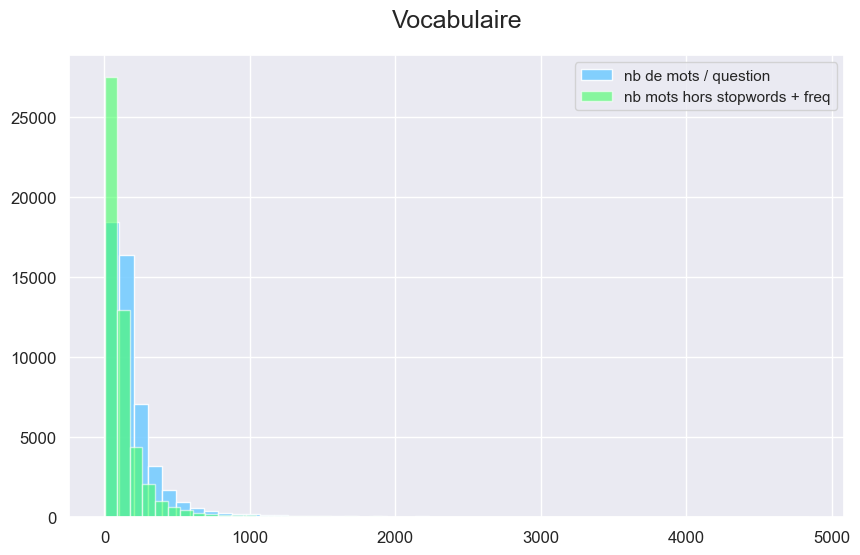

In [135]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'nb_mots'
raw_questions_tags['nb_tokens_body'].hist(density=False, bins=50, ax=ax, color='#7cf', alpha=0.9, label='nb de mots / question')

# Plotting 'nb_mots non stopwords'
raw_questions_tags['nb_tokens_body_no_stopwords'].hist(density=False, bins=50, color='#4f6', ax=ax,
                                                          alpha=0.6, label='nb mots hors stopwords + freq')

plt.title('Vocabulaire', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()

plt.show()


### 2.6 Lemmatization + filtrage syntaxique


In [136]:
# + filtrage implicite du vocabulaire non-anglais

# Lemmatization tends to be more accurate but can be slower than stemming.
# On a utilisé le stemming en français, dans le cours openclassrooms
# Utilisons la lemmatisation ici, + appropriée pour notre objectif
# (extraire le sens important, le thème, pour proposer des tags)
# On peut aussi profiter de l'analyse grammaticale (POS) pour
# conserver uniquement les mots les plus "importants" dans la phrase, les noms et les verbes.

def preprocess_3_lemmatize(tokens, filter=True):
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(pos_tag):
        if pos_tag.startswith('J'):
            return wordnet.ADJ
        elif pos_tag.startswith('R'):
            return wordnet.ADV
        elif pos_tag.startswith('V'):
            return wordnet.VERB
        elif pos_tag.startswith('N'):
            return wordnet.NOUN
        else:
            return wordnet.NOUN  # Default to noun if the part of speech is not recognized

    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize each token
    lemmatized_tokens = []
    for token, pos_tag in pos_tags:
        if filter and pos_tag.startswith(('J', 'R')):
            # Exclude adjectives (J) and adverbs (R) if filter is enabled
            lemmatized_tokens.append(" ")
        else:
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos_tag)))

    return lemmatized_tokens

# Assuming raw_questions_tags is a DataFrame with a column 'tokens_uniques_no_stopwords'
# Replace 'tokens_uniques_no_stopwords' with the actual column name if needed
raw_questions_tags['body_lemms'] = raw_questions_tags['body_tokens_no_stopwords'].parallel_apply(preprocess_3_lemmatize)


In [137]:
raw_questions_tags['title_lemms'] = raw_questions_tags['title_tokens_no_stopwords'].parallel_apply(preprocess_3_lemmatize)


### 2.7 tokens (lemms) uniques


In [138]:
# On aurait pu procéder à cette étape bien plus tôt (juste après l'étude de fréquences)
# et ainsi économiser du temps de calcul et de l'espace mémoire, mais on se garde ainsi
# la possibilité de tester notre LDA (notebook 3) sur un bag-of-words "classique".

def preprocess_4_keep_uniques_only(liste_tokens):
    seen_tokens = set()
    unique_tokens = []

    for token in liste_tokens:
        if token not in seen_tokens:
            seen_tokens.add(token)
            unique_tokens.append(token)

    return unique_tokens

# Apply the preprocessing function to body
raw_questions_tags['body_lemms_uniques'] = raw_questions_tags['body_lemms'].parallel_apply(preprocess_4_keep_uniques_only)


In [139]:
# and title
raw_questions_tags['title_lemms_uniques'] = raw_questions_tags['title_lemms'].parallel_apply(preprocess_4_keep_uniques_only)


In [140]:
raw_questions_tags['nb_lemms_uniques_body'] = raw_questions_tags['body_lemms_uniques'].apply(len)
raw_questions_tags['nb_lemms_uniques_title'] = raw_questions_tags['title_lemms_uniques'].apply(len)

display(raw_questions_tags.describe())

display(raw_questions_tags)

# Légère baisse pour les titres, en revanche
# le nb de tokens dans les questions (body) est divisé par 2 !


,nb_tokens_body,nb_tokens_title,nb_tokens_body_no_stopwords,nb_tokens_title_no_stopwords,nb_lemms_uniques_body,nb_lemms_uniques_title
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,199.352280,9.363800,132.523920,6.339880,52.36420,5.761300
std,243.059224,3.678146,194.909476,2.388614,42.86152,1.997669
min,7.000000,1.000000,2.000000,0.000000,2.00000,0.000000
25%,80.000000,7.000000,45.000000,5.000000,26.00000,4.000000
50%,134.000000,9.000000,79.000000,6.000000,41.00000,5.000000
75%,229.000000,11.000000,146.000000,8.000000,64.00000,7.000000
max,4845.000000,33.000000,4330.000000,29.000000,1009.00000,19.000000


,title,body,tags,body_tokens,title_tokens,nb_tokens_body,nb_tokens_title,body_tokens_no_stopwords,title_tokens_no_stopwords,nb_tokens_body_no_stopwords,nb_tokens_title_no_stopwords,body_lemms,title_lemms,body_lemms_uniques,title_lemms_uniques,nb_lemms_uniques_body,nb_lemms_uniques_title
0,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,<python><flask><importerror><flask-login><werk...,"[i, am, building, a, webapp, using, flask, i, ...","[importerror, can, not, import, name, url_deco...",765,9,"[building, webapp, using, flask, imported, fla...","[importerror, import, name, url_decode, werkze...",674,6,"[building, webapp, use, flask, import, , , ...","[importerror, import, name, , werkzeug, url]","[building, webapp, use, flask, import, , hand...","[importerror, import, name, , werkzeug, url]",150,6
1,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...",<spring-boot><compiler-errors><upgrade><lombok...,"[after, upgrading, to, jdk, 21, i, have, the, ...","[compilation, error, after, upgrading, to, jdk...",42,16,"[upgrading, jdk, 21, following, compilation, e...","[compilation, error, upgrading, jdk, 21, nosuc...",32,11,"[upgrade, jdk, 21, follow, compilation, error,...","[compilation, error, upgrade, jdk, 21, nosuchf...","[upgrade, jdk, 21, follow, compilation, error,...","[compilation, error, upgrade, jdk, 21, nosuchf...",24,11
2,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,<chatbot><openai-api><langchain><large-languag...,"[i, m, currently, working, on, developing, a, ...","[differences, between, langchain, llamaindex]",155,4,"[currently, working, developing, chatbot, powe...","[differences, langchain, llamaindex]",80,3,"[ , work, develop, chatbot, power, , language...","[difference, langchain, llamaindex]","[ , work, develop, chatbot, power, language, m...","[difference, langchain, llamaindex]",51,3
3,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,<python><amazon-web-services><docker><google-c...,"[i, am, running, a, docker, image, from, a, do...","[session, not, created, this, version, of, chr...",475,12,"[running, docker, image, docker, container, aw...","[session, created, version, chromedriver, supp...",398,8,"[run, docker, image, docker, container, aws, b...","[session, create, version, chromedriver, suppo...","[run, docker, image, container, aws, batch, en...","[session, create, version, chromedriver, suppo...",151,7
4,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,<java><spring-boot><eclipse><spring-security><...,"[when, i, try, to, run, an, application, it, f...","[spring, security, method, can, not, decide, p...",509,15,"[try, run, application, fails, start, throws, ...","[spring, security, method, decide, pattern, mv...",436,10,"[try, run, application, fail, , throw, except...","[spring, security, method, decide, pattern, mv...","[try, run, application, fail, , throw, except...","[spring, security, method, decide, pattern, mv...",115,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,<c#><winforms><pdf><.net-4.0><printing>,"[here, s, the, basic, premise, my, user, click...","[how, can, i, send, a, file, document, to, the...",165,14,"[basic, premise, user, clicks, pdf, file, spit...","[send, file, document, printer, print]",79,5,"[ , premise, user, click, pdf, , spit, deskto...","[send, file, document, printer, print]","[ , premise, user, click, pdf, spit, desktop, ...","[send, file, document, printer, print]",48,5
49996,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...",<visual-studio><visual-studio-2010><dll><style...,"[when, i, run, stylecop, i, got, this, error, ...","[ca1014, mark, some,

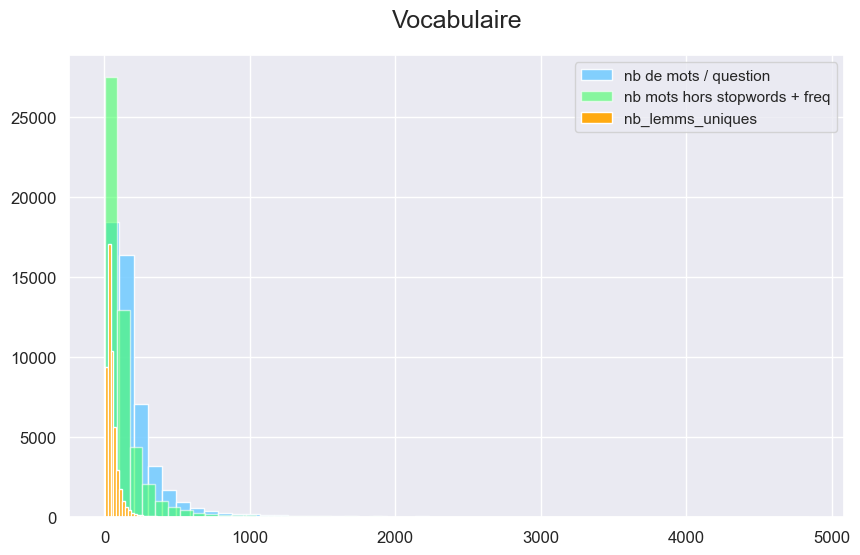

In [141]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'nb_mots'
raw_questions_tags['nb_tokens_body'].hist(density=False, bins=50, ax=ax, color='#7cf', alpha=0.9, label='nb de mots / question')

# Plotting 'nb_mots non stopwords'
raw_questions_tags['nb_tokens_body_no_stopwords'].hist(density=False, bins=50, color='#4f6', ax=ax,
                                                          alpha=0.6, label='nb mots hors stopwords + freq')

# Plotting 'lemms uniques'
raw_questions_tags['nb_lemms_uniques_body'].hist(density=False, bins=50, color='#fa1', ax=ax,
                                                          alpha=1.0, label='nb_lemms_uniques')

plt.title('Vocabulaire', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()

plt.show()

# On voit une petite différence !


In [142]:
# Extract tokens from the 'tokens_uniques' column
all_lemms = set(([token for tokens_list in raw_questions_tags['title_lemms_uniques'] for token in tokens_list]
                 + [token for tokens_list in raw_questions_tags['body_lemms_uniques'] for token in tokens_list]))

print(len(all_lemms))
# Notre corpus a été divisé par 8 environ.


130487


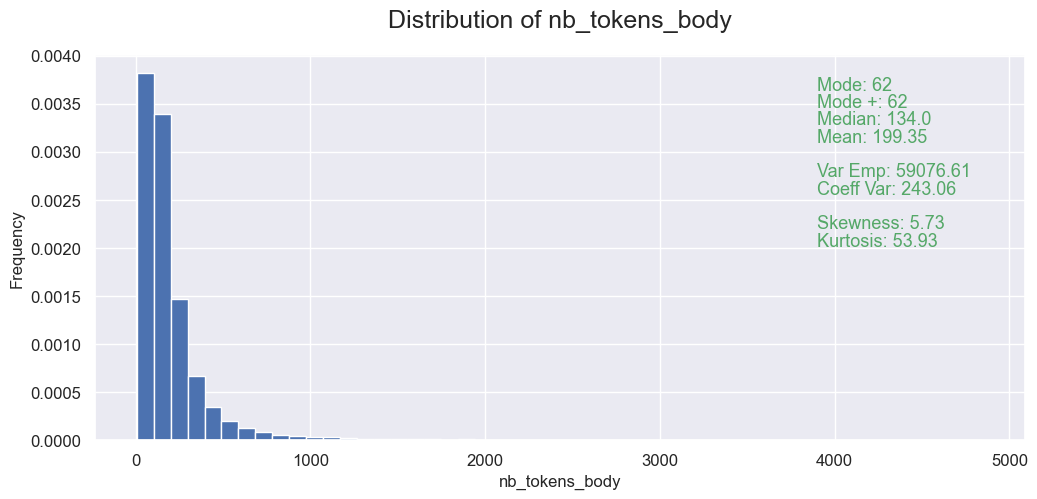

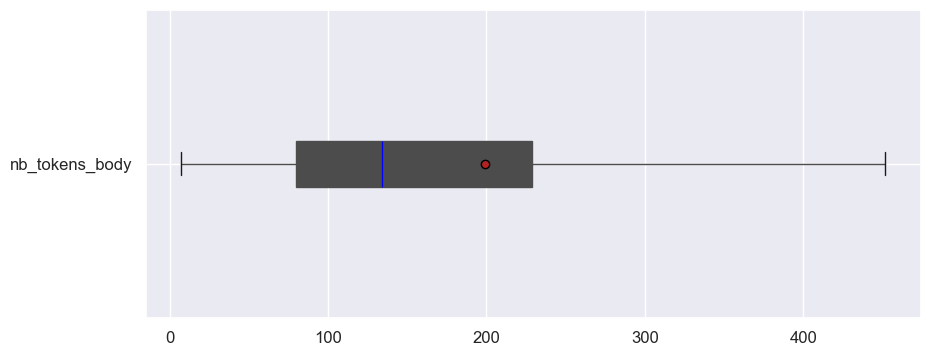

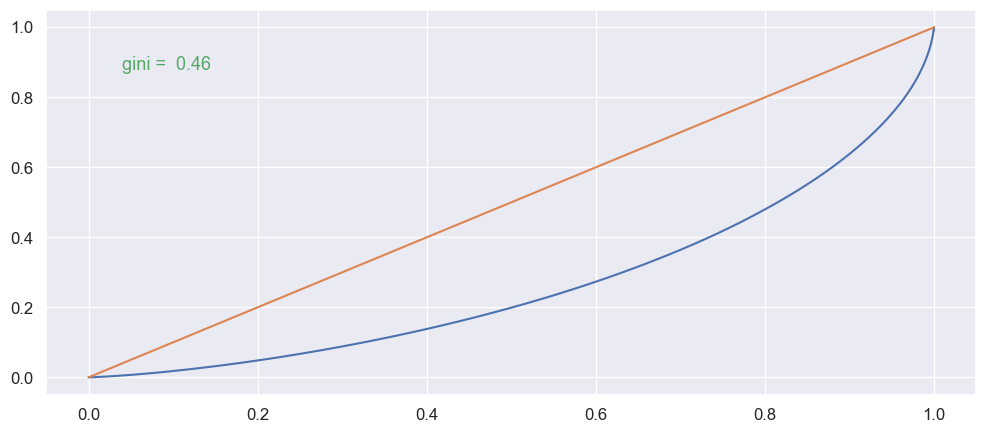

In [143]:
# Corpus de départ
graphs_analyse_uni(raw_questions_tags, 'nb_tokens_body', bins=50, r=2, density=True)


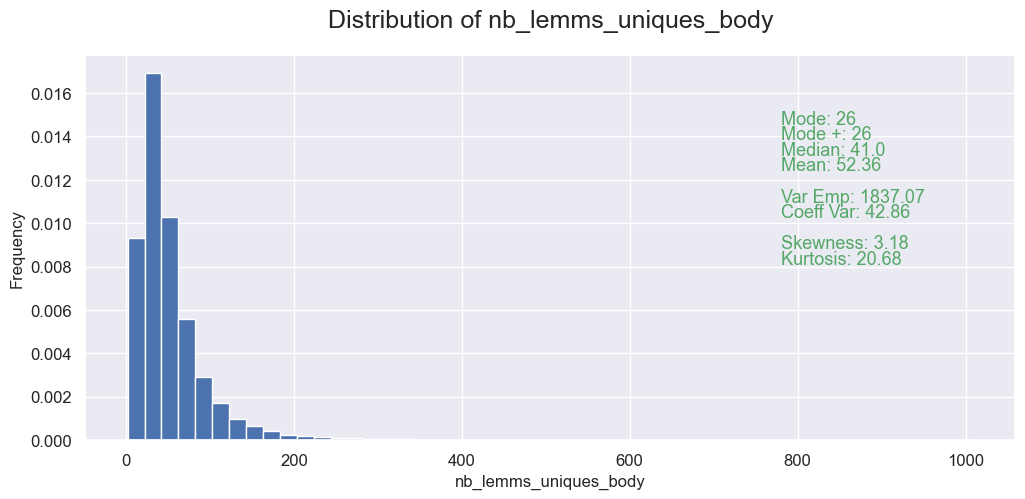

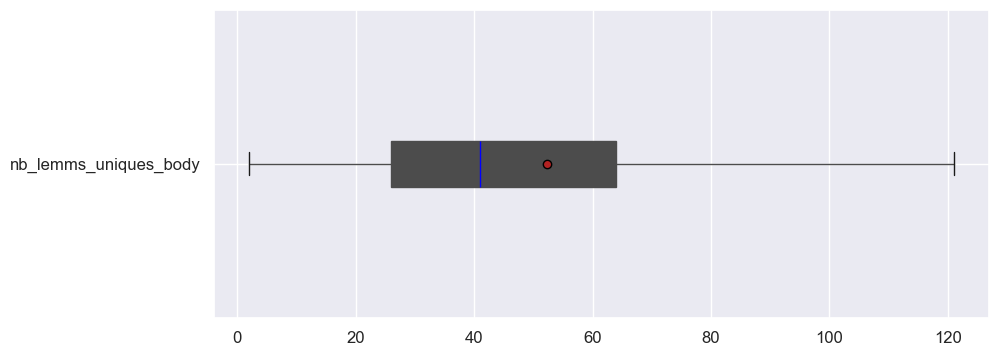

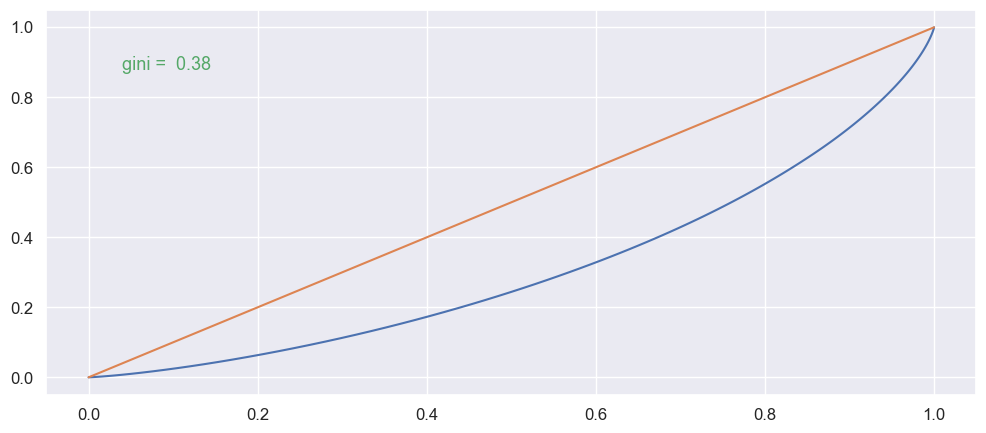

In [144]:
# Corpus d'arrivée
graphs_analyse_uni(raw_questions_tags, 'nb_lemms_uniques_body', bins=50, r=2, density=True)

# Moyenne divisée par 4


### 2.8 Explorer le corpus obtenu


In [145]:
# Affichons 20 questions au hasard (+ les tags)
display(raw_questions_tags.sample(20))


,title,body,tags,body_tokens,title_tokens,nb_tokens_body,nb_tokens_title,body_tokens_no_stopwords,title_tokens_no_stopwords,nb_tokens_body_no_stopwords,nb_tokens_title_no_stopwords,body_lemms,title_lemms,body_lemms_uniques,title_lemms_uniques,nb_lemms_uniques_body,nb_lemms_uniques_title
28909,"Java - char, int conversions","In Java, the following is allowed:\nchar c = '...",<java><char><type-conversion><int><variable-as...,"[in, java, the, following, is, allowed, char, ...","[java, char, int, conversions]",88,4,"[java, following, allowed, char, c, c, hold, v...","[java, char, int, conversions]",48,4,"[java, follow, allow, , c, c, hold, value, b,...","[java, char, int, conversion]","[java, follow, allow, , c, hold, value, b, ex...","[java, char, int, conversion]",24,4
27030,Getting error: ISO C++ forbids declaration of ...,I'm getting the following errors:\n\nISO C++ f...,<c++><function><class><constructor><declaration>,"[i, m, getting, the, following, errors, iso, c...","[getting, error, iso, c, forbids, declaration,...",109,10,"[getting, following, errors, iso, c, forbids, ...","[getting, error, iso, c, forbids, declaration,...",79,7,"[get, follow, error, iso, , forbids, declarat...","[get, error, iso, c, forbids, declaration, type]","[get, follow, error, iso, , forbids, declarat...","[get, error, iso, c, forbids, declaration, type]",33,7
9173,"Open a file (pdf, word, excel, png etc.) on de...",I'm using react-native-fs to download a file(p...,<android><ios><react-native><react-native-fetc...,"[i, m, using, react, native, fs, to, download,...","[open, a, file, pdf, word, excel, png, etc, on...",238,17,"[using, react, native, fs, download, file, pdf...","[open, file, pdf, word, excel, png, etc, devic...",174,12,"[use, , , f, download, file, pdf, word, exce...","[ , file, pdf, word, excel, png, etc, device, ...","[use, , f, download, file, pdf, word, excel, ...","[ , file, pdf, word, excel, png, etc, device, ...",80,11
28132,Best way to convert Doctrine 2 entity persiste...,What is best way (easy) to convert Doctrine 2 ...,<json><doctrine-orm><frameworks><zend-framewor...,"[what, is, best, way, easy, to, convert, doctr...","[best, way, to, convert, doctrine, 2, entity, ...",48,15,"[best, way, easy, convert, doctrine, 2, entity...","[best, way, convert, doctrine, 2, entity, pers...",28,12,"[ , way, , , doctrine, 2, entity, , collect...","[ , way, , doctrine, 2, entity, , collection...","[ , way, doctrine, 2, entity, collection, arra...","[ , way, doctrine, 2, entity, collection, arra...",18,9
39564,What is the workaround for using dynamic SQL i...,The Stored Procedure\nDELIMITER $$\n\nCREATE P...,<mysql><sql><database><stored-procedures><trig...,"[the, stored, procedure, delimiter, create, pr...","[what, is, the, workaround, for, using, dynami...",163,12,"[stored, procedure, delimiter, create, procedu...","[workaround, using, dynamic, sql, stored, proc...",106,6,"[ , procedure, delimiter, create, procedure, l...","[workaround, use, , sql, store, procedure]","[ , procedure, delimiter, create, lms, begin, ...","[workaround, use, , sql, store, procedure]",47,6
34918,Writing a single unit test for multiple implem...,I have an interface List whose implementations...,<java><unit-testing><junit><junit4><junit-runner>,"[i, have, an, interface, list, whose, implemen...","[writing, a, single, unit, test, for, multiple...",100,11,"[interface, list, whose, implementations, incl...","[writing, single, unit, test, multiple, implem...",58,7,"[interface, list, whose, implementation, inclu...","[write, , unit, test, , implementation, inte...","[interface, list, whose, implementation, inclu...","[write, , unit, test, implementation, interface]",27,6
36526,Mutex lock threads,Am new to multi threaded/processs programming....,<c><linux><pthreads><mutex><multiprocess>,"[am, new, to, multi, threaded, processs, progr...","[mutex, lock, threads]",76,3,"[new, multi, threaded, processs, programming, ...","[mutex, lock, threads]",45,3,"[ , multi, thread, p

In [146]:
# Pistes restantes

# Le preprocessing de nos questions est assez satisfaisant, il répond à nos objectifs.
# Pour aller + loin, on pourrait par exemple examiner plus attentivement les valeurs numériques,
# les dates, URLs, adresses Email, noms propres, etc...

# Ces traitements plus avancés peuvent vite devenir horriblement compliqués
# avec un pur traitement nltk + regex, sans être jamais complètement satisfaisants.
# Filtrer les dates par exemple, juste les dates... C'est déjà un travail colossal à cause des
# (très) nombreux formats possibles.
# Identifier les noms propres... c'est simplement impossible sans machine learning.

# Nous allons donc en profiter pour tester spacy, qui est orienté objet et utilise différents modèles
# préentrainés. (cf partie 4)

# Avant cela, intéressons-nous aux tags, qui sont nos futures targets.


## 3 EDA et preprocessing des targets


### 3.1 Convertion (string to list)


In [147]:
def convert_tags_string_to_list(tags_string):
    # just in case
    tags_string = tags_string.lower()
    # Split tags by '><'
    tags_list = tags_string.split('><')

    # Remove angle brackets from the first and last tag
    tags_list[0] = tags_list[0][1:]
    tags_list[-1] = tags_list[-1][:-1]

    return tags_list

# Apply the preprocessing function to the 'tags' column
raw_questions_tags['tags_list'] = raw_questions_tags['tags'].apply(convert_tags_string_to_list)

display(raw_questions_tags[['tags', 'tags_list']].head(10))


,tags,tags_list
0,<python><flask><importerror><flask-login><werk...,"[python, flask, importerror, flask-login, werk..."
1,<spring-boot><compiler-errors><upgrade><lombok...,"[spring-boot, compiler-errors, upgrade, lombok..."
2,<chatbot><openai-api><langchain><large-languag...,"[chatbot, openai-api, langchain, large-languag..."
3,<python><amazon-web-services><docker><google-c...,"[python, amazon-web-services, docker, google-c..."
4,<java><spring-boot><eclipse><spring-security><...,"[java, spring-boot, eclipse, spring-security, ..."
5,<python><python-3.x><google-chrome><selenium-w...,"[python, python-3.x, google-chrome, selenium-w..."
6,<ios><flutter><xcode><macos><build>,"[ios, flutter, xcode, macos, build]"
7,<python><nlp><importerror><huggingface-transfo...,"[python, nlp, importerror, huggingface-transfo..."
8,<firebase><next.js><oauth-2.0><firebase-authen...,"[firebase, next.js, oauth-2.0, firebase-authen..."
9,<javascript><node.js><reactjs><babeljs><ejs>,"[javascript, node.js, reactjs, babeljs, ejs]"


In [148]:
raw_questions_tags['nb_tags'] = raw_questions_tags['tags_list'].apply(len)
raw_questions_tags['nb_tags'].describe()

# min : 5
# max : 6
# Un intervalle plutôt réduit.


count    50000.000000
mean         5.000040
std          0.006324
min          5.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          6.000000
Name: nb_tags, dtype: float64

### 3.2 Corpus des tags, Doublons éventuels


In [149]:
all_tags = [tag for tags in raw_questions_tags['tags_list'] for tag in tags]
print(len(all_tags))

# Au cas où il y aurait des doublons ds les tags
raw_questions_tags['tags_uniques'] = raw_questions_tags['tags'].apply(preprocess_4_keep_uniques_only)

# Fréquence
# Factoriser ?
tag_frequencies_dict = {}
for tag in all_tags:
    tag_frequencies_dict[tag] = tag_frequencies_dict.get(tag, 0) + 1

# Sort the dictionary items by values in descending order
sorted_tag_frequencies = dict(sorted(tag_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Display the first 50 items in the tag frequencies dictionary
for tag, frequency in list(sorted_tag_frequencies.items())[:50]:
    print(f"{tag}: {frequency}")

# 250 000 tags (différents) !
# Ca repond a la question : est-ce qu'un humain pourrait facilement faire cette tache.
# Il faudrait déjà connaitre ts les tags possibles... Pas évident.

# Le tag le plus présent est python
# Est-ce qu'il y a plus de codeurs en python qu'en javascript ?
# Peut-être. Pas sûr.
# Est-ce qu'on va sur stack overflow plus souvent quand on fait du python ?
# Je dirais que oui. Il y a tjs de nveaux modules à découvrir en python !

# Classement intéressant !


250002
python: 6500
javascript: 6174
java: 6097
c#: 4728
android: 4265
ios: 4024
html: 2500
c++: 2086
node.js: 1965
php: 1929
jquery: 1858
.net: 1787
css: 1736
objective-c: 1550
spring: 1542
swift: 1412
linux: 1304
iphone: 1302
reactjs: 1287
json: 1236
xcode: 1215
sql: 1177
asp.net: 1103
pandas: 1029
python-3.x: 1015
arrays: 925
c: 911
mysql: 906
asp.net-mvc: 904
typescript: 880
angular: 877
spring-boot: 857
windows: 818
unit-testing: 806
django: 796
string: 779
ruby-on-rails: 772
macos: 714
numpy: 677
database: 676
angularjs: 657
sql-server: 644
laravel: 644
rest: 640
postgresql: 635
dataframe: 632
bash: 631
amazon-web-services: 621
asp.net-core: 609
docker: 608


### 3.3 Frequences des tags


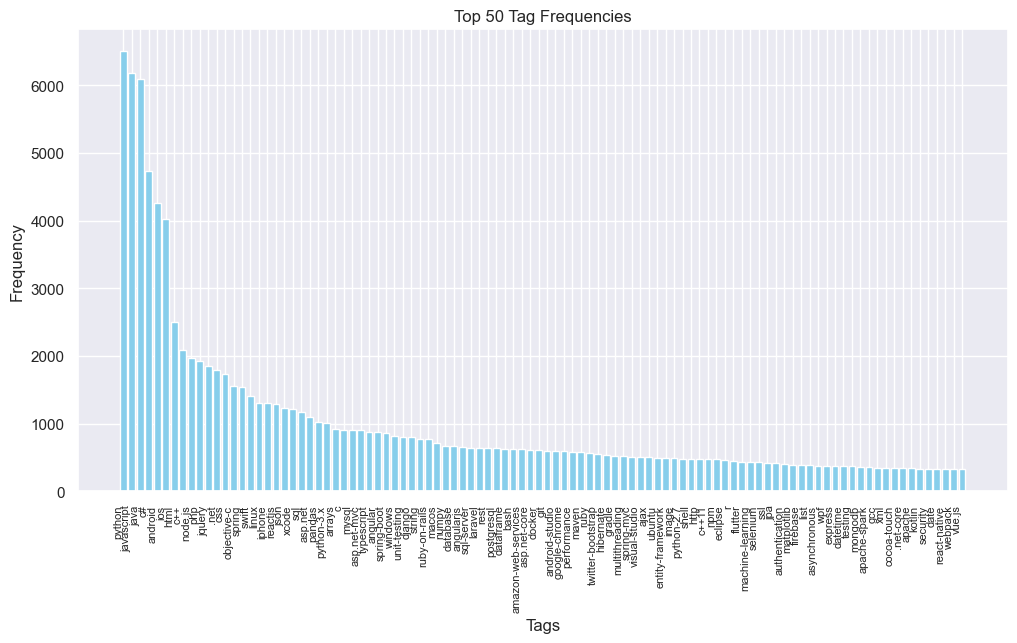

In [150]:
# Extract tags and frequencies
tags = list(sorted_tag_frequencies.keys())
frequencies = list(sorted_tag_frequencies.values())

# Plot
plt.figure(figsize=(12, 6))
plt.bar(tags[:100], frequencies[:100], color='skyblue')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 50 Tag Frequencies')
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate x-axis labels for better readability
plt.show()


### 3.4 Les 20 tags les + frequents


,Tag,Frequency
0,python,6500
1,javascript,6174
2,java,6097
3,c#,4728
4,android,4265
5,ios,4024
6,html,2500
7,c++,2086
8,node.js,1965
9,php,1929


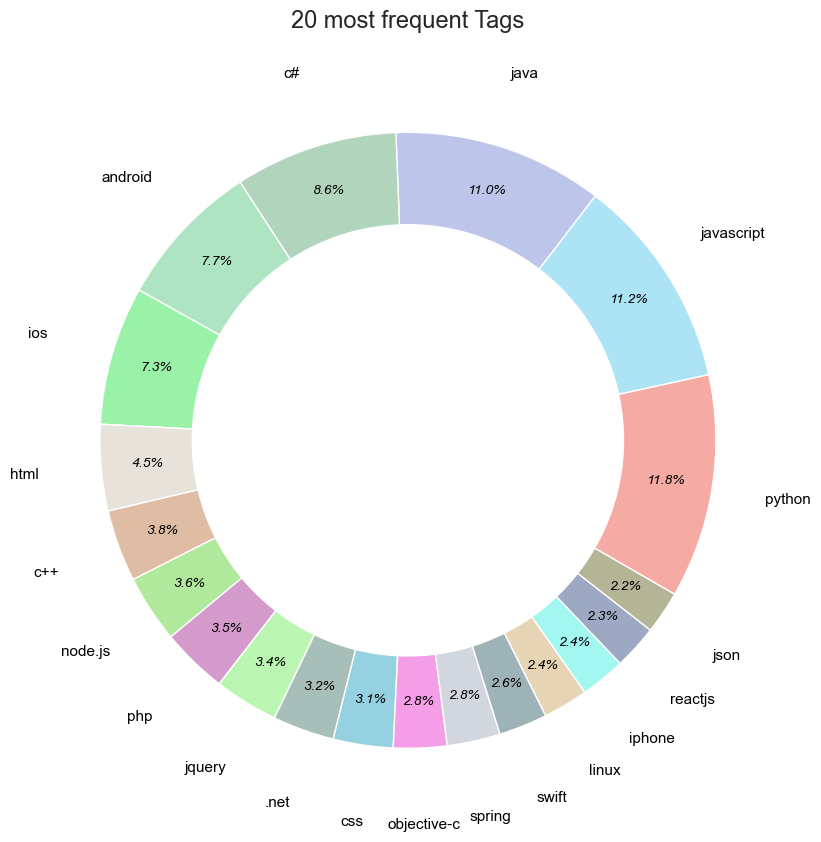

In [151]:
# + d'un tiers des question concernent python, js ou java.

# Faisons un top 20
df_freq = pd.DataFrame({'Tag': tags, 'Frequency': frequencies})

# Display the DataFrame
display(df_freq.head(20))

# plot a pie
colors = generate_random_pastel_colors(20)

fig, ax = plt.subplots(figsize=(10, 10))

patches, texts, autotexts = plt.pie(x=df_freq['Frequency'][:20], autopct='%1.1f%%',
    startangle=-30, labels=df_freq['Tag'][:20], textprops={'fontsize':11, 'color':'#000'},
    labeldistance=1.25, pctdistance=0.85, colors=colors)

plt.title(
label='20 most frequent Tags',
fontdict={"fontsize":17},
pad=20
)

for text in texts:
    # text.set_fontweight('bold')
    text.set_horizontalalignment('center')

# Customize percent labels
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    autotext.set_fontstyle('italic')
    autotext.set_fontsize('10')

#draw circle
centre_circle = plt.Circle((0,0),0.7,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()


### 3.5 Tags rares


In [152]:
# A l'inverse, certains tags sont rares

# Count tags with frequency less than 10
tags_below_10 = sum(1 for frequency in sorted_tag_frequencies.values() if frequency < 10)
print(tags_below_10)

# voire tres rares
# tags hapax (1 seule occurence)

# Count tags with frequency less than 2
tags_below_2 = sum(1 for frequency in sorted_tag_frequencies.values() if frequency < 2)
print(tags_below_2)

# On les supprime ?
# seuil ?


13253
6526


### 3.6 WordCloud


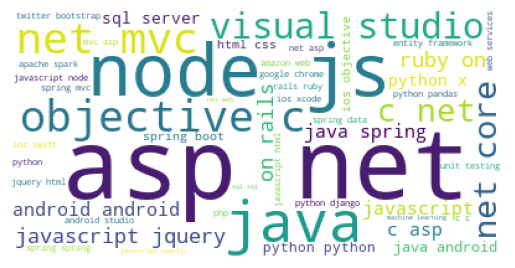

In [153]:
def show_cloud(list):
    cloud = WordCloud(background_color='white',
                    stopwords=[],
                    max_words=50).generate(" ".join(list))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()


show_cloud(all_tags)
# Pourquoi python tout petit ?? C le tag le + frequent !


In [154]:
# analyse multi
# Nous allons rapidement visualiser les wordclouds des 5 tags les + fréquents.

most_frequent_tags = tags[:5]
print(most_frequent_tags)

subsets = dict()

for t in most_frequent_tags:
    subsets[t] = [tag for tags in raw_questions_tags['tags_list'] for tag in tags if t in tags]


['python', 'javascript', 'java', 'c#', 'android']


Tag : python


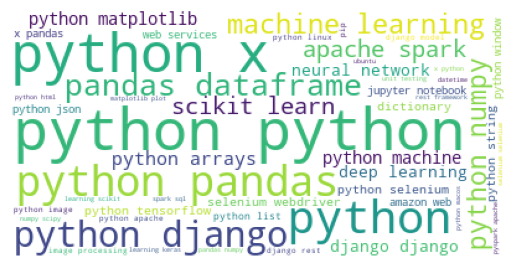

Tag : javascript


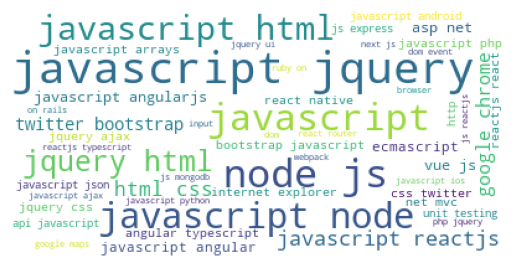

Tag : java


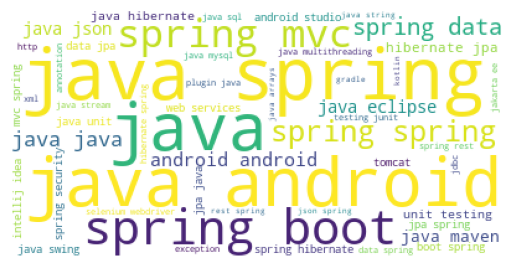

Tag : c#


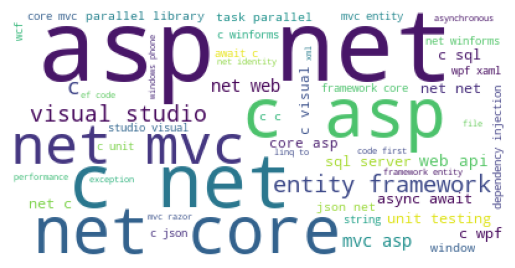

Tag : android


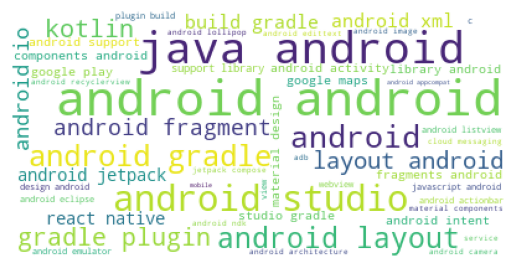

In [155]:
for subset in subsets:
    print(f'Tag : {subset}')
    show_cloud(subsets[subset])


Tag : python


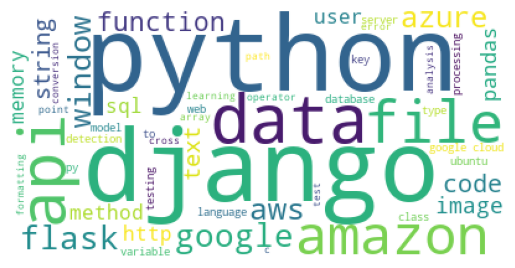

Tag : javascript


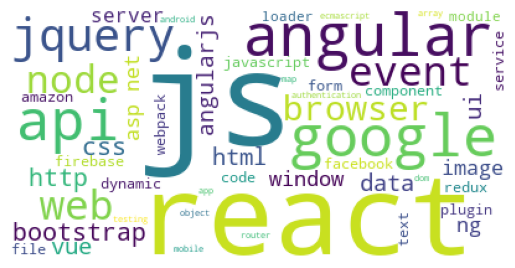

Tag : java


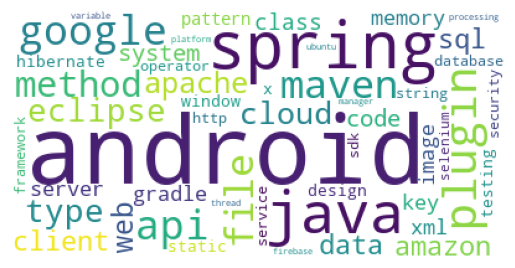

Tag : c#


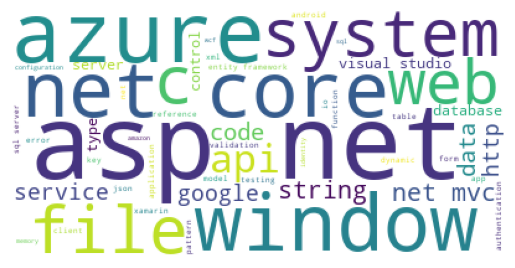

Tag : android


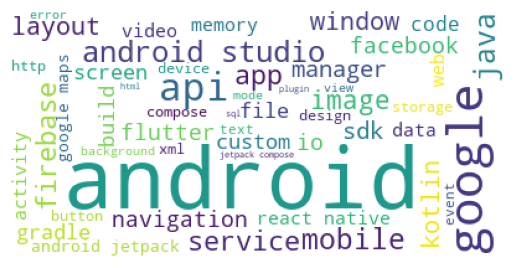

In [156]:
# Sans les répétitions :

for subset in subsets:
    print(f'Tag : {subset}')
    show_cloud(set(subsets[subset]))

# C'est plus parlant !


## 4 Spacy


## Normalisation
